# Starbucks Capstone Project

## Table of Contents
1. [Project Overview](#PO)<br>
2. [Exploratory Data Analysis](#EDA)<br>
    - [Portfolio Assessment & Cleaning](#PAC1)<br>
    - [Profile Assessment & Cleaning](#PAC2)<br>
    - [Transcript Assessment & Cleaning](#TAC)<br>
3. [Modelling](#MDL)<br>
    - [Data Preprocessing](#DPP)<br>
    - [Implementation](#IMP)<br>
    - [Refinement](#REF)<br>
4. [Evaluation](#EVA)<br>
5. [Conclusion](#CLN)<br>

<a id='PO'></a>
## 1. Project Overview

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

In this analysis, we will combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. 

### Problem Statement

This is the final project in Udacity's Data Scientist Nanodegree. The purpose of this project is to use and demonstrate the Software, Date, and ML Engineering techniques learned in this program on specially curated data provided by Starbucks.

The defining questions to be answered in this project are:

**Question 1. Which are the defining features of an effective offer?**

**Question 2. Can these features be used to predict whether an offer will be effective? (binary classification)**


### Implementation

As we will soon see in the EDA section, there are 3 types of offers in the dataset.

1. BOGO
2. Discount
3. Informational

In order to answer 'Question 1.' posed in this project, 3 separate classification models will be created for each of the 3 types of offers in the dataset.

In order to answer 'Question 2.', the `feature_importances_` function will be used display the most *important* feature in each respective model.


### Metrics

The models generated in this project will be assessed through **accuracy** and **f1** scores.

Optimal parameters for the models will be determined using the `grid_search` function.

Models for each offer type will be compared and the best one selected for each.

*In addition to accuracy, f1-score is a useful measurement in determining model efficacy. The f1-score is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the accuracy metric. f1-score is a particular useful metric in cases involving imbalanced datasets.* [source](medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2)

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

<a id='EDA'></a>
## 2. Exploratory Data Analysis

In [2]:
!pip install -U matplotlib

    100% |████████████████████████████████| 11.5MB 3.8MB/s eta 0:00:01
    100% |████████████████████████████████| 49.4MB 783kB/s eta 0:00:01   13% |████▏                           | 6.5MB 56.1MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 1.7MB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 30.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for pillow ... done
  Stored in directory: /root/.cache/pip/wheels/a7/69/9a/bba9fca6782340f88dbc378893095722a663cbc618e58fe401
Successfully built pillow
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: m

In [3]:
import pandas as pd
import numpy as np
import math
import json
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<a id='PAC1'></a>
### Portfolio Assessment

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio.id.nunique()

10

In [6]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


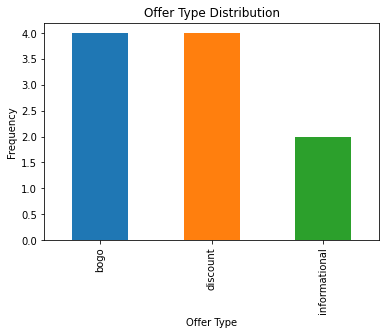

In [9]:
ax = portfolio.offer_type.value_counts().plot.bar() 
ax.set_title("Offer Type Distribution")
ax.set_xlabel("Offer Type")
ax.set_ylabel("Frequency")
plt.show();

The portfolio dataset is small, containing only 10 entries pertaining to the various offers available to customers.
- 4 bogo
- 4 discount
- 2 informational

Fortunately, the dataset contained no null values or duplicates. So the only preliminary cleaning required is:
- rename `id` column to `offer_id`

The `channels` column is a candidate for re-engineering during the model pre-processing stage.

### Portfolio Cleaning

In [10]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [11]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


<a id='PAC2'></a>
### Profile Assessment

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
profile.id.nunique()

17000

In [15]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [16]:
profile[profile['age'] > 80].age.value_counts()

118    2175
81      118
82      105
83      102
84       83
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, dtype: int64

In [17]:
import matplotlib
matplotlib.__version__

'3.3.4'

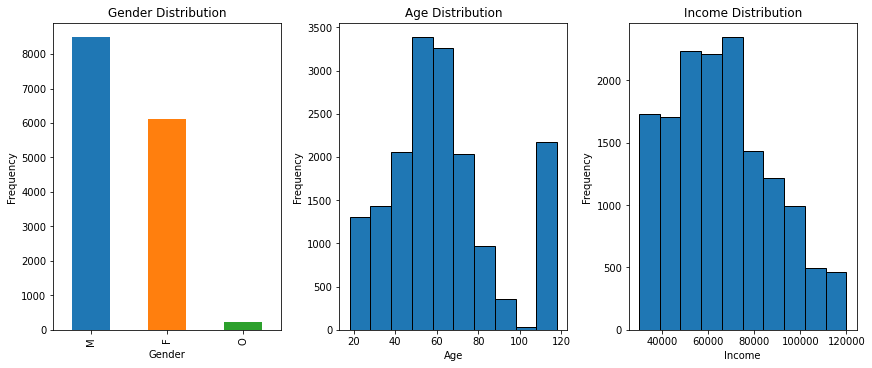

In [18]:
fig, ax= plt.subplots(1,3,figsize=(12,5), constrained_layout=True)

# GENDER Distribution
profile.gender.value_counts().plot.bar(ax=ax[0]) 
ax[0].set_title("Gender Distribution")
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("Frequency")

# Age Distribution
profile.age.plot.hist(ax=ax[1], edgecolor='black') 
ax[1].set_title("Age Distribution")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Frequency")

# Income Distribution
profile.income.plot.hist(ax=ax[2], edgecolor='black') 
ax[2].set_title("Income Distribution")
ax[2].set_xlabel("Income")
ax[2].set_ylabel("Frequency")

plt.show();

The profile dataset contains information on 17000 unique customers. Notable columns are:
- age
- income
- gender

Cleaning Points:
- rename `id` column to `customer_id`
- Remove customers erroneous aged 118+
- Roughly 10% of entries in this dataset are missing values in columns `age` and `income` and will therefore be removed.
- The `became_member_on` column not that useful as it is, but could be more useful if re-engineered into something like `years_of_membership`.

From the graphs it is apparent that:
- the dataset has more self-identified Males than Females, and a small number of self-identified Other.
- Age is almost normally distributed. Children and young people don't seem to frequent Starbucks until their 20s, with usage increasing until their 60s, and then tapering off from that point.
- Income is right skewed, with most people's income falling between 49k-80k (IQR).

### Profile Cleaning

In [19]:
profile.rename(columns = {'id': 'customer_id'}, inplace = True)

In [20]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [21]:
profile = profile[profile['age'] != 118]

In [22]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
customer_id         14825 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


In [23]:
profile.became_member_on = profile.became_member_on.apply(lambda x: 2018 - int(str(x)[:4]))
profile.rename({'became_member_on': 'years_of_membership'}, axis=1, inplace=True)

In [24]:
profile.sample(5)

,age,years_of_membership,gender,customer_id,income
4893,27,2,M,6563b069be9741189ad1ebed59ed1b4c,40000.0
5251,52,2,F,f3acf14291c040a5b6d93bdd426898c6,68000.0
14050,52,0,M,55aff3035b87496c91b2e916ab120dfd,87000.0
12453,70,2,F,95e0cad7dc6d4c8cbeb09629d9c1b6b7,57000.0
9128,82,2,M,cd1162e65d84441db217e275af71a7e5,74000.0


<a id='TAC'></a>
### Assess Transcript

In [25]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [28]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

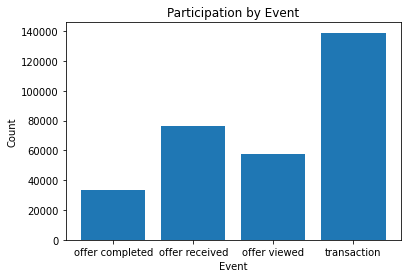

In [29]:
event_list = ['offer completed', 'offer received', 'offer viewed', 'transaction']
event_participation = list(transcript.groupby('event').person.count())
x_pos = list(range(len(event_list)))

plt.bar(x_pos, event_participation)
plt.xticks(x_pos, event_list)
plt.ylabel('Count')
plt.xlabel('Event')
plt.title('Participation by Event')

plt.show()

The transaction dataset contains 306534 non-null entries containing customers's transaction data. The key to extracting insights about customer behaviour and offer effectiveness will be in sorting and manipulating this dataset to separate effective offers from ineffective and even useless offers.

For preliminary cleaning:
- rename `person` column to `customer_id`
- extract `offer_id` column from `value` column

### Transcript Cleaning

In [30]:
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

In [31]:
transcript_value_list = []
for i in range(len(transcript.value)):
    if (transcript.value[i].keys()) not in transcript_value_list:
        transcript_value_list.append(transcript.value[i].keys())
transcript_value_list

[dict_keys(['offer id']),
 dict_keys(['amount']),
 dict_keys(['offer_id', 'reward'])]

In [32]:
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id', x.get('offer_id', np.nan)))
transcript.drop(columns=['value'], inplace=True)

In [33]:
transcript.sample(10)

,event,customer_id,time,offer_id
15574,transaction,6747dda08bed46298c23e05b64820a3a,6,NaN
150784,offer received,2a01c11fdcc441bcbdc842c35adccb2f,408,4d5c57ea9a6940dd891ad53e9dbe8da0
59714,offer received,61d7edeec0114a9197aa11bef76e227d,168,f19421c1d4aa40978ebb69ca19b0e20d
266355,offer viewed,b6f5973f9af041038f4eea606c2b9234,588,3f207df678b143eea3cee63160fa8bed
213108,offer received,9e6978ac56214d83aa97812c1f37549c,504,4d5c57ea9a6940dd891ad53e9dbe8da0
276001,transaction,95ef73ccde5740e5ba055c9ff322ae68,606,NaN
244675,transaction,4d0142b1561949a289acbcf0245cbbc6,570,NaN
219572,offer viewed,8a7ee6531f1043feb0c398b8e4549e41,510,ae264e3637204a6fb9bb56bc8210ddfd
64234,offer received,d1bd7a6be57a496eaecbc77b1119b3b2,168,9b98b8c7a33c4b65b9aebfe6a799e6d9
161762,offer received,8ee581b9251e4000923afc441415b4a0,408,ae264e3637204a6fb9bb56bc8210ddfd


<a id='MDL'></a>
## 3. Modelling

<a id='DPP'></a>
### Preprocessing
**One-Hot Encode Portfolio & Profile Dataframes**

The Profile and Portfolio dataframes have features that will be useful in building models for different offers. In order to be used in the modelling process, some of these features will have to undergo one-hot-encoding.

Then these features can be merged to the transcript dataframe for eventual modelling.

In [34]:
portfolio_channels = portfolio.channels.tolist()
channels = []
for channel_list in portfolio_channels:
    for channel in channel_list:
        channels.append(channel)
channels = set(channels)

In [35]:
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x:1 if channel in x else 0 )
portfolio.drop(columns=['channels'], inplace=True)
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,mobile,email,web,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,1,0


In [36]:
profile = pd.concat([profile[:], pd.get_dummies(profile['gender'], dtype=int)], axis=1)
profile.drop(columns='gender', inplace=True)
profile.head()

,age,years_of_membership,customer_id,income,F,M,O
1,55,1,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
3,75,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
5,68,0,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
8,65,0,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
12,58,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


**Merge Dataframes**

In [37]:
merged_df = transcript.merge(portfolio, on = 'offer_id', how = 'left')
merged_df = merged_df.merge(profile, on = 'customer_id', how = 'right')

In order to create accurate models, it's necessary to examine and categorize the different types of outcomes that can occur with an offer.

In [38]:
merged_df.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15258
                 discount         17186
offer received   bogo             26537
                 discount         26664
                 informational    13300
offer viewed     bogo             22039
                 discount         18461
                 informational     9360
Name: offer_type, dtype: int64

There are 4 event types (`offer completed`, `offer received`, `offer viewed`, `transaction`), however the `transaction` type does not have an `offer_id` associated with it (instead the `amount` of the transaction was recorded). Therefore, the first step is to associate transactions with a specific `offer_id`s.

While bogo and dicount offers have an `offer completed` event to mark offer completion, informational offers do not, and will therefore require a different method to verify offer completion.

The rules dictating the different types of outcome are illustrated below.

![offer_outcome_types](https://udacity-user-uploads.s3.us-west-2.amazonaws.com/uploads/user-uploads/c5bf09be-8921-4658-a658-b2aaf8004c6c-desktop.jpeg)

[source](https://knowledge.udacity.com/questions/845663)

In [39]:
merged_processed = merged_df.sort_values(['customer_id', 'time'])
merged_processed.sample(5)

,event,customer_id,time,offer_id,difficulty,duration,offer_type,reward,mobile,email,web,social,age,years_of_membership,income,F,M,O
132305,transaction,3697a921add94ccd8a91c735875932df,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,1,93000.0,0,1,0
12096,offer received,0990624579434298afa4aa83a1202e72,504,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,0.0,1.0,1.0,0.0,1.0,60,0,81000.0,1,0,0
143996,transaction,3636eb17c0634c65933e2d90600e8462,486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,1,36000.0,0,1,0
107321,offer received,f56c66ea1083462f9841bdfed32a71a1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,0.0,1.0,1.0,0.0,20,2,72000.0,0,1,0
81444,transaction,5e60c6aa3b834e44b822ea43a3efea26,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,4,55000.0,0,1,0


In [40]:
transaction_list = merged_processed['event'] == 'transaction'
viewed_list = merged_processed['event'] == 'offer viewed'
received_list = merged_processed['event'] == 'offer received'
completed_list = merged_processed['event'] == 'offer completed'

In [41]:
offer_completed = merged_processed[['time', 'offer_id', 'customer_id', 'event']][transaction_list | viewed_list].groupby(['customer_id', 'offer_id']).ffill()
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [42]:
offer_completed.head(5)

,customer_id,offer_id,time,event
252234,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,offer viewed
252235,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction
252237,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,offer viewed
252239,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction
252241,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed


In [43]:
merged_processed = merged_processed.merge(offer_completed, on = ['customer_id', 'time', 'event'], how = 'left')
merged_processed.head(5)

,event,customer_id,time,offer_id_x,difficulty,duration,offer_type,reward,mobile,email,web,social,age,years_of_membership,income,F,M,O,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,0.0,1.0,1.0,0.0,1.0,33,1,72000.0,0,1,0,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,0.0,1.0,1.0,0.0,1.0,33,1,72000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,1,72000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,33,1,72000.0,0,1,0,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,33,1,72000.0,0,1,0,3f207df678b143eea3cee63160fa8bed


In [44]:
merged_processed['offer_id'] = np.where(merged_processed['offer_id_x'].isnull(),\
                                            merged_processed['offer_id_y'], merged_processed['offer_id_x'])
merged_processed.drop(columns = ['offer_id_x', 'offer_id_y'], axis=1, inplace=True)

In [45]:
merged_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 18 columns):
event                  272762 non-null object
customer_id            272762 non-null object
time                   272762 non-null int64
difficulty             148805 non-null float64
duration               148805 non-null float64
offer_type             148805 non-null object
reward                 148805 non-null float64
mobile                 148805 non-null float64
email                  148805 non-null float64
web                    148805 non-null float64
social                 148805 non-null float64
age                    272762 non-null int64
years_of_membership    272762 non-null int64
income                 272762 non-null float64
F                      272762 non-null int64
M                      272762 non-null int64
O                      272762 non-null int64
offer_id               272762 non-null object
dtypes: float64(8), int64(6), object(4)
memory usage: 39.5+

**Now that all transactions have an associated offer_id, it is necessary to identify transactions completed specifically after viewing an offer.**

In [46]:
# filter the data by offer viewed, transaction, and offer completed
transactions_after_viewed = merged_processed[viewed_list | transaction_list | completed_list].copy()

# create the previous offer id
transactions_after_viewed['previous_offer_id'] = transactions_after_viewed.groupby(['customer_id', 'offer_id'])['offer_id'].shift()

# create flag for completed offer when transaction complete after customer viewed the offer
transactions_after_viewed['valid_completion'] = np.where(transactions_after_viewed['previous_offer_id'] == transactions_after_viewed['offer_id'], 1, 0)

In [47]:
# add 'offer received' to event
offer_received = merged_processed[merged_processed['event'] == 'offer received']

offer_received['previous_offer_id'] = np.nan
offer_received['valid_completion'] = np.nan

merged_processed = offer_received.append(transactions_after_viewed).sort_values(['customer_id', 'time'])
merged_processed.head()

,event,customer_id,time,difficulty,duration,offer_type,reward,mobile,email,web,social,age,years_of_membership,income,F,M,O,offer_id,previous_offer_id,valid_completion
0,offer received,0009655768c64bdeb2e877511632db8f,168,0.0,3.0,informational,0.0,1.0,1.0,0.0,1.0,33,1,72000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,0.0,3.0,informational,0.0,1.0,1.0,0.0,1.0,33,1,72000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,1,72000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,33,1,72000.0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,336,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,33,1,72000.0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0


**Since the offer types have different criteria for completion, let's separate them for ease of analysis.**

In [48]:
#split transcript into 3 different offer types
bogo_df = merged_processed[merged_processed['offer_type'] == 'bogo'].copy()
discount_df = merged_processed[merged_processed['offer_type'] == 'discount'].copy()
informational_df = merged_processed[merged_processed['offer_type'] == 'informational'].copy()

In [49]:
display(bogo_df.sample(5))
display(discount_df.sample(5))
display(informational_df.sample(5))

,event,customer_id,time,difficulty,duration,offer_type,reward,mobile,email,web,social,age,years_of_membership,income,F,M,O,offer_id,previous_offer_id,valid_completion
162199,offer received,9831341c3d0840219ce2b4cd6ac0dd54,336,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,40,4,33000.0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
252471,offer received,ecb3be2f4d4940e0ba4093d1f05b05b9,408,10.0,7.0,bogo,10.0,1.0,1.0,0.0,1.0,73,3,46000.0,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,1.0
33617,offer received,208bf54c363a4542bfe02328b47b9912,168,10.0,7.0,bogo,10.0,1.0,1.0,0.0,1.0,20,4,73000.0,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN
207858,offer received,c2b2d67d84494302a7aa517899b58da0,576,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,49,3,60000.0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0
71788,offer received,43471d98a3a84930ab5bb1cd7c09f108,168,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,62,0,67000.0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


,event,customer_id,time,difficulty,duration,offer_type,reward,mobile,email,web,social,age,years_of_membership,income,F,M,O,offer_id,previous_offer_id,valid_completion
84616,offer viewed,4f1932bb4f1440e397f33a19ecce2f47,528,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0,60,0,71000.0,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0
75037,offer viewed,46298e83bf0148a2ab87021c9e1e42cf,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,45,1,99000.0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,1.0
88461,offer viewed,52e27ce4fb99466dab3e0666e10dc0e8,174,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0,46,3,68000.0,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0
163395,offer received,99589ef8a7824f78adef69de2275c8fa,408,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0,67,1,91000.0,0,1,0,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,1.0
96119,offer viewed,5a7fd20781d64e8baaef972ac4c9e7ce,336,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0,62,0,55000.0,1,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0


,event,customer_id,time,difficulty,duration,offer_type,reward,mobile,email,web,social,age,years_of_membership,income,F,M,O,offer_id,previous_offer_id,valid_completion
78729,offer viewed,497661c41c2c412b89e33f3403712cee,426,0.0,3.0,informational,0.0,1.0,1.0,0.0,1.0,52,3,82000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0
175297,offer received,a3d8dd50c46540a1a47fdbe29ebe3a56,336,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,67,3,86000.0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
127708,offer received,78e9be059fce46a1b610f74e0e812a4a,168,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,77,2,80000.0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
129012,offer received,79f083ca34ce4d27a37d98a5ceb83592,576,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,34,4,59000.0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
35604,offer received,2297b19f7fdb4ca3bcb1cbf74209b77b,504,0.0,3.0,informational,0.0,1.0,1.0,0.0,1.0,31,2,60000.0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN


**Next identify customers who viewed transactions without completing them, and customers that received an offer but did not even view it. aka group 1 customers**

In [50]:
def effective_offers(df):
    
    '''
    Extracts effective offers from bogo and discount datasets.
    
    input:
    - df:                   bogo or discount dataframe

    output:
    - effective_offers:    dataframe of effective offers
       
    '''
    effective_offers = df[['customer_id', 'offer_id']][(df['valid_completion'] == 1) & (df['event'] == 'offer completed')].groupby(['customer_id', 'offer_id']).count().reset_index()
    return effective_offers

In [51]:
bogo_completed = effective_offers(bogo_df)
discount_completed = effective_offers(discount_df)

In [52]:
# # extract responded offer under bogo and informational type
# bogo_completed = bogo_df[['customer_id', 'offer_id']][(bogo_df['valid_completion'] == 1) &\
#                                                       (bogo_df['event'] == 'offer completed')]\
#                                                       .groupby(['customer_id', 'offer_id']).count().reset_index()

# discount_completed = discount_df[['customer_id','offer_id']][(discount_df['valid_completion'] == 1) &\
#                                                           (discount_df['event'] == 'offer completed')].groupby(['customer_id','offer_id']).count().reset_index()

In [53]:
# # select only transactions or completed, and offers which are 'viewed'
# def viewed_non_complete(df):
    
#     '''
#     input:
#     - df:         discount or bogo dataframe
    
#     output:
#     - viewed_non_complete:  dataframe of offers viewed without transaction or completion
#     '''
    
#     transaction_completed = df[['customer_id', 'offer_id']][(df['event'] == 'transaction') |\
#                                                                   (df['event'] == 'offer completed') ].groupby(['customer_id', 'offer_id']).count().reset_index()
    
#     ids_received = df[['customer_id', 'offer_id']][df['event'] == 'offer received'].groupby(['customer_id', 'offer_id']).count().reset_index()
    
#     viewed_non_complete = transaction_completed.merge(ids_received, on = ['customer_id', 'offer_id'], how = 'right', indicator = True)
    
#     return viewed_non_complete


In [54]:
# bogo_merged = viewed_non_complete(bogo_df)
# bogo_merged.head(5)

In [55]:
# discount_merged = viewed_non_complete(discount_df)
# discount_merged.head(5)

In [56]:
# # for bogo offers, select only transactions or completed, and offers which are 'viewed'
# bogo_transaction_completed = bogo_df[['customer_id', 'offer_id']][(bogo_df['event']=='transaction') |\
#                                                                   (bogo_df['event']=='offer completed') ].groupby(['customer_id', 'offer_id']).count().reset_index()

# bogo_ids_received = bogo_df[['customer_id', 'offer_id']][bogo_df['event'] == 'offer received'].groupby(['customer_id', 'offer_id']).count().reset_index()

# # get the offers that were viewed without transaction or completion
# bogo_merged = bogo_transaction_completed.merge(bogo_ids_received, on = ['customer_id', 'offer_id'], how = 'right', indicator = True)
# bogo_merged.head()

In [57]:
# # for discount offers, select only transactions or completed, and offers which are 'viewed'
# discount_transaction_completed = discount_df[['customer_id', 'offer_id']][(discount_df['event'] == 'transaction') |\
#                                                                            (discount_df['event'] == 'offer completed') ].groupby(['customer_id', 'offer_id']).count().reset_index()

# discount_ids_received = discount_df[['customer_id', 'offer_id']][discount_df['event'] == 'offer received'].groupby(['customer_id', 'offer_id']).count().reset_index()

# # get the discount offers that were viewed without transaction or completion
# discount_merged = discount_transaction_completed.merge(discount_ids_received, on=['customer_id', 'offer_id'], how = 'right', indicator = True)
# discount_merged.head()

From the merged datasets, can finally distinguish between customers who viewed their offers and customers who did not even view their offers at all (after receiving an offer).

In [58]:
def ineffective_view(df):
    
    '''
    input:
    - df:                   bogo or discount dataframe
    
    output:
    - viewed_no_complete:   dataframe of offers viewed but not completed
    - no_view:              dataframe of offers not even viewed
    '''
    
    transaction_completed = df[['customer_id', 'offer_id']][(df['event'] == 'transaction') |\
                                                                  (df['event'] == 'offer completed') ].groupby(['customer_id', 'offer_id']).count().reset_index()
    
    ids_received = df[['customer_id', 'offer_id']][df['event'] == 'offer received'].groupby(['customer_id', 'offer_id']).count().reset_index()
    
    viewed_non_complete = transaction_completed.merge(ids_received, on = ['customer_id', 'offer_id'], how = 'right', indicator = True)
    
    
    no_transaction = viewed_non_complete[viewed_non_complete['_merge'] == 'right_only']
    no_transaction = no_transaction.merge(merged_processed, on = ['customer_id', 'offer_id'], how = 'left')

    # subselect customers that only veiwed the offer and customers that viewed but did not complete the bogo offer
    viewed_no_complete = no_transaction[['customer_id', 'offer_id']][no_transaction['event'] == \
                                                                  'offer viewed'].groupby(['customer_id', 'offer_id']).count().reset_index()

    no_transaction.drop(['_merge'], axis=1, inplace=True)

    # selects customers that did not even view their bogo offer 
    no_view = no_transaction.merge(viewed_no_complete[['customer_id', 'offer_id']], how = 'left', indicator = True)
    no_view = no_view[no_view['_merge'] == 'left_only'].copy()
    
    return viewed_no_complete, no_view

In [59]:
bogo_viewed_no_complete, bogo_no_view = ineffective_view(bogo_df)

In [60]:
discount_viewed_no_complete, discount_no_view = ineffective_view(discount_df)

In [61]:
# # select customers that received an offer but did not complete it
# bogo_no_transaction = bogo_merged[bogo_merged['_merge'] == 'right_only']
# bogo_no_transaction = bogo_no_transaction.merge(merged_processed, on=['customer_id', 'offer_id'], how = 'left')
 
# # subselect customers that only veiwed the offer and customers that viewed but did not complete the bogo offer
# bogo_viewed = bogo_no_transaction[['customer_id', 'offer_id']][bogo_no_transaction['event'] == \
#                                                               'offer viewed'].groupby(['customer_id', 'offer_id']).count().reset_index()

# bogo_no_transaction.drop(['_merge'], axis=1, inplace=True)

# # selects customers that did not even view their bogo offer 
# bogo_no_view = bogo_no_transaction.merge(bogo_viewed[['customer_id', 'offer_id']], how = 'left', indicator = True)
# bogo_no_view = bogo_no_view[bogo_no_view['_merge'] == 'left_only'].copy()

In [62]:
bogo_viewed_no_complete.shape

(7552, 2)

In [63]:
discount_viewed_no_complete.shape

(4920, 2)

In [64]:
# # subtract the customers who received the offer without finishing the transaction
# discount_no_transaction = discount_merged[discount_merged['_merge'] == 'right_only']
# discount_no_transaction = discount_no_transaction.merge(merged_processed, on=['customer_id', 'offer_id'], how='left')

# # subselect customers that only veiwed the offer and customers that viewed but did not complete the discount offer
# discount_viewed = discount_no_transaction[['customer_id', 'offer_id']][discount_no_transaction['event'] == \
#                                                                        'offer viewed'].groupby(['customer_id','offer_id']).count().reset_index()

# discount_no_transaction.drop(['_merge'], axis=1, inplace=True)

# # selects customers that did not even view their discount offer 
# discount_no_view = discount_no_transaction.merge(discount_viewed[['customer_id', 'offer_id']], how='left', indicator=True)
# discount_no_view = discount_no_view[discount_no_view['_merge'] == 'left_only'].copy()

Now to identify customers who performed transactions independent of receiving/viewing offers.

In [65]:
# select offers which have no effect on customer transaction/offer completion
bogo_independent = bogo_df[['customer_id', 'offer_id']][(bogo_df['event'] == \
                                                    'offer completed') & (bogo_df['valid_completion'] !=1 )].groupby(['customer_id', 'offer_id']).count().reset_index()

discount_independent = discount_df[['customer_id', 'offer_id']][(discount_df['event'] == \
                                                            'offer completed') & (discount_df['valid_completion'] != 1)].groupby(['customer_id', 'offer_id']).count().reset_index()

Now that the different offer outcomes have been identified and separated customers who perform transactions after receiving an offer and customers who viewed offers but did not perform any subsequent transactions.

In [66]:
# combine the two kind of cases, either customer responded to offer (AKA bogo_completed) or just view (AKA bogo_viewed)
bogo_completed['effective_offer'] = 1
bogo_viewed_no_complete['effective_offer'] = 0
bogo_offer = bogo_completed.append(bogo_viewed_no_complete, sort=False)

# combine the two kind of cases, either customer responded to offer (AKA discount_completed) or just view (AKA discount_viewed)
discount_completed['effective_offer'] = 1
discount_viewed_no_complete['effective_offer'] = 0
discount_offer = discount_completed.append(discount_viewed_no_complete, sort=False)

Informational offers require a different approach - they can only be counted as 'completed' if the customer spends the necessary amount within the time period of the offer.

In [67]:
informational_df = informational_df.reset_index()

In [68]:
#convert time into days
informational_df['offer_in_days'] = informational_df['time']/24

informational_df.drop(['time', 'previous_offer_id'], axis=1, inplace=True)
informational_df = informational_df.sort_values(['customer_id', 'offer_in_days', 'event', 'offer_id'])

#get difference in time for informational offers
informational_df['time_diff'] = informational_df[(informational_df['offer_type'] == 'informational') \
                                    & ((informational_df['event'] == 'offer received') \
                                       | (informational_df['event'] == 'transaction'))].groupby(['customer_id', 'offer_id'])['offer_in_days'].diff()

informational_df['completion_in_time'] = np.nan

#assign offer completed within timeframe
informational_df.loc[informational_df['time_diff'] <= informational_df['duration'], 'completion_in_time'] = 1

#assign missing values as 0
informational_df['completion_in_time'] = informational_df['completion_in_time'].fillna(value = 0)

In [69]:
informational_df.sample(10)

,index,event,customer_id,difficulty,duration,offer_type,reward,mobile,email,web,...,years_of_membership,income,F,M,O,offer_id,valid_completion,offer_in_days,time_diff,completion_in_time
25415,228730,offer received,d6f10a8cda5b41049c57f1a076227c14,0.0,4.0,informational,0.0,1.0,1.0,1.0,...,2,98000.0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,17.00,NaN,0.0
29892,269085,offer received,fc69570a2ba74e92b1bf03cc30b1c66a,0.0,4.0,informational,0.0,1.0,1.0,1.0,...,2,64000.0,0,1,0,3f207df678b143eea3cee63160fa8bed,0.0,21.00,0.0,1.0
10611,95767,offer received,5a1fba0d6d0e4cb183abc82b4ed586df,0.0,3.0,informational,0.0,1.0,1.0,0.0,...,1,33000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,0.0,7.00,0.0,1.0
22225,200633,offer received,bb3983180f0f4b019976c13d5106ce11,0.0,3.0,informational,0.0,1.0,1.0,0.0,...,1,64000.0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.00,0.0,1.0
23430,211170,offer viewed,c65f7b5cfa674dee9a2af2618d8674e9,0.0,4.0,informational,0.0,1.0,1.0,1.0,...,0,31000.0,0,1,0,3f207df678b143eea3cee63160fa8bed,1.0,10.75,NaN,0.0
22795,205571,offer received,c030d78db17e4a7da30432c6624b2496,0.0,4.0,informational,0.0,1.0,1.0,1.0,...,2,94000.0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,17.00,NaN,0.0
1744,15826,offer received,0f0c770d5eaa4ebe9ca67f8c5c240f76,0.0,4.0,informational,0.0,1.0,1.0,1.0,...,2,77000.0,1,0,0,3f207df678b143eea3cee63160fa8bed,0.0,7.00,0.0,1.0
3254,29967,offer received,1ce8e5faa25f4daabdf8c43c1168cb17,0.0,3.0,informational,0.0,1.0,1.0,0.0,...,1,33000.0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,17.00,NaN,0.0
2695,25048,offer received,1823f88cc0df46bbbdad2e82afd3c9b7,0.0,3.0,informational,0.0,1.0,1.0,0.0,...,2,69000.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,1.0,24.00,0.0,1.0
3769,34905,offer viewed,21ef657d74c5446987e8b18d8166d0ed,0.0,3.0,informational,0.0,1.0,1.0,0.0,...,2,109000.0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,1.0,14.25,NaN,0.0


Only transaction completed within the effective offer duration are considered as successful.

In [70]:
#Consider offers with valid_completion=1 and completion_in_time=1 as successfully responded to

informational_df['effective_offer'] = np.where(((informational_df['valid_completion'] == 1) \
                                                & (informational_df['completion_in_time'] == 1)), 1, 0)

In [71]:
# get the sum of completed offers by customer
informational_completed = informational_df[['customer_id','offer_id']][informational_df['effective_offer']==1]\
                        .groupby(['customer_id','offer_id']).sum().reset_index()

In [72]:
# for informational offers, select only transactions or completed, and offers which are 'viewed'

informational_ids_transaction_completed = informational_df[['customer_id', 'offer_id']][(informational_df['event'] == \
                                                            'transaction') | (informational_df['event'] == 'offer completed') ].groupby(['customer_id', 'offer_id']).count().reset_index()

informational_ids_received = informational_df[['customer_id', 'offer_id']][informational_df['event'] == 'offer received'].groupby(['customer_id', 'offer_id']).count().reset_index()

# get the offers that were viewed without transaction or completion
informational_merged = informational_ids_transaction_completed.merge(informational_ids_received, on=['customer_id','offer_id'], how='right', indicator=True)
informational_merged.head()

,customer_id,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,right_only
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,right_only
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,right_only
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,right_only
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,right_only


In [73]:
# subtract the customers who received the offer without finishing the transaction
informational_no_transaction = informational_merged[informational_merged['_merge'] == 'right_only']
informational_no_transaction = informational_no_transaction.merge(merged_processed, on = ['customer_id','offer_id'], how='left')

# subselect customers that only veiwed the offer and customers that viewed but did not complete the informational offer
informational_viewed = informational_no_transaction[['customer_id', 'offer_id']][informational_no_transaction['event'] == \
                                                                'offer viewed'].groupby(['customer_id', 'offer_id']).count().reset_index()

informational_no_transaction.drop(['_merge'], axis = 1, inplace = True)

# selects customers that did not even view their informational offer 
informational_no_view = informational_no_transaction.merge(informational_viewed[['customer_id', 'offer_id']], how='left', indicator=True)
informational_no_view = informational_no_view[informational_no_view['_merge'] == 'left_only'].copy()

In [74]:
# combine the two kind of cases, either customer responded to offer (AKA informational_completed) or just view (AKA informational_viewed)
informational_completed['effective_offer'] = 1
informational_viewed['effective_offer'] = 0
informational_offer = informational_completed.append(informational_viewed, sort=False)

**Finally, merge the profile, portfolio, and fully processed dataframes whose features will be used in model.**

In [75]:
def merge_processed_datasets(df):
    
    '''
    input:
    - df:       processed bogo, discount, or informational dataframe with effective_offer as the intended target variable
    
    ouput:
    - df_full:  processed dataframe merged with profile and portfolio dataframes to use their features in the model
    '''
    
    offer_profile = df.merge(profile, on = 'customer_id', how = 'left')
    df_full = offer_profile.merge(portfolio, on = 'offer_id', how = 'inner')
    
    return df_full

In [76]:
bogo_full = merge_processed_datasets(bogo_offer)
bogo_full.sample(1)

,customer_id,offer_id,effective_offer,age,years_of_membership,income,F,M,O,difficulty,duration,offer_type,reward,mobile,email,web,social
16663,b22c0e74398046bd94c404285b01cd16,ae264e3637204a6fb9bb56bc8210ddfd,0,80,0,73000.0,1,0,0,10,7,bogo,10,1,1,0,1


In [77]:
discount_full = merge_processed_datasets(discount_offer)
discount_full.sample(1)

,customer_id,offer_id,effective_offer,age,years_of_membership,income,F,M,O,difficulty,duration,offer_type,reward,mobile,email,web,social
5373,9ca81fd80e3a4648a06ac124eb40805c,fafdcd668e3743c1bb461111dcafc2a4,1,56,4,80000.0,0,1,0,10,10,discount,2,1,1,1,1


In [78]:
informational_full = merge_processed_datasets(informational_offer)
informational_full.sample(1)

,customer_id,offer_id,effective_offer,age,years_of_membership,income,F,M,O,difficulty,duration,offer_type,reward,mobile,email,web,social
7329,cc0de70feab44d65a3829e75308a6848,3f207df678b143eea3cee63160fa8bed,0,83,1,61000.0,0,1,0,0,4,informational,0,1,1,1,0


In [79]:
# bogo_offer_profile = bogo_offer.merge(profile, on = 'customer_id', how = 'left')
# bogo_full = bogo_offer_profile.merge(portfolio, on = 'offer_id', how = 'inner')
# bogo_full.sample(1)

In [80]:
# discount_offer_profile = discount_offer.merge(profile, on = 'customer_id', how = 'left')
# discount_full = discount_offer_profile.merge(portfolio, on = 'offer_id', how = 'inner')
# discount_full.sample(1)

In [81]:
# informational_offer_profile = informational_offer.merge(profile, on = 'customer_id', how = 'left')
# informational_full = informational_offer_profile.merge(portfolio, on = 'offer_id', how = 'inner')
# informational_full.sample(1)

<a id='IMP'></a>
### Model Implementation

Now the datasets are ready.

Looking back to our initial goal - to predict the likelihood of an offer being responded to or not (according to the newly generated `effective_offer` feature), and to see how accurately we can predict this feature.

Since there were 3 different offer types, 3 different models will be built. As these models must predict whether an offer will be responded to, the models will fall under the binary classification category.

A Decision Tree classifier will be used as the baseline model from which to assess the performance of refined random forest classifiers.

Before running the models, let's assess the spread of `effective_offer` amongst the different offer types.

In [82]:
#check the distribution of the offer_responed feature
print(bogo_full[['customer_id', 'effective_offer']].groupby('effective_offer').count()/len(bogo_full))
print(discount_full[['customer_id', 'effective_offer']].groupby('effective_offer').count()/len(discount_full))
print(informational_full[['customer_id', 'effective_offer']].groupby('effective_offer').count()/len(informational_full))

                 customer_id
effective_offer             
0                   0.436305
1                   0.563695
                 customer_id
effective_offer             
0                   0.311412
1                   0.688588
                 customer_id
effective_offer             
0                     0.7928
1                     0.2072


**The informational dataset is imbalanced, having (~80% ineffective orders), which may negatively impact the accuracy of the informational model.**

<a id='MTR'></a>
###  Training

Prep > Build Pipeline > Train & Test Measurement > Run Model > View Results

In [83]:
def data_prep(df, cols_to_drop):
    
    '''
    input:
    - df:           dataframe to insert into the model
    - cols_to_drop: columns to exclude from the dataframe
    
    output:
    - target:   dataframe containing only target column
    - features: dataframe containing the rest of the columns in the dataframe excluding those in cols_to_drop
    '''
    
    target = df['effective_offer']
    features = df.drop(cols_to_drop, axis = 1, inplace = False)
    
    return features, target

In [84]:
def model_pipeline(features, target):
    
    '''
    input:
    - features: dataframe containing the features used to predict the target
    - target:   dataframe containing only the target variable for the model
    
    output:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #divide training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.30, random_state = 30)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale and test data
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [85]:
# reference: Udacity -- 'Finding Donors for Charity ML' project
# reference: Udacity -- 'Creating Customer Segments with Arvato' project
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    start = time.time() 
    model = model.fit(X_train, y_train)
    end = time.time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time.time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time.time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['train_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['test_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Train accuracy:%.4f" % results['train_score'])
    print("Test accuracy:%.4f" % results['test_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [86]:
# reference: Udacity -- 'Finding Donors for Charity ML' project
# reference: Udacity -- 'Creating Customer Segments with Arvato' project

def run_model(clf1, clf2, name):
    
    '''
    input:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    output:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect the results of the models' performances
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' + name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    
    return pd.DataFrame(results)

### BOGO Model

In [87]:
# generate model for bogo offers

cols_to_drop = ['customer_id', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(bogo_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# initialize the baseline and bogo models
decisiontree_baseline = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 3, min_samples_split = 30, min_samples_leaf = 30)
bogo_randomforest_1 = RandomForestClassifier(random_state = 3, max_depth = 3, max_features = 'auto', min_samples_split = 30, n_estimators = 30, min_samples_leaf=30)

results = run_model(decisiontree_baseline, bogo_randomforest_1, 'bogo_1')

DecisionTreeClassifier trained on 12116 samples.
MSE_train: 0.3537
MSE_test: 0.3680
Train accuracy:0.6463
Test accuracy:0.6320
             precision    recall  f1-score   support

          0     0.5753    0.6319    0.6023      2290
          1     0.6852    0.6321    0.6576      2903

avg / total     0.6368    0.6320    0.6332      5193

RandomForestClassifier trained on 12116 samples.
MSE_train: 0.3293
MSE_test: 0.3380
Train accuracy:0.6707
Test accuracy:0.6620
             precision    recall  f1-score   support

          0     0.6673    0.4659    0.5487      2290
          1     0.6597    0.8167    0.7299      2903

avg / total     0.6631    0.6620    0.6500      5193



- The RandomForest model (66.2%) was *more* **accurate** than than the DecisionTree model (63%)
- The RandomForest model **f1-score** (65%) was *higher* than than the DecisionTree model **f1-score** (63.0%)

### Discount Model

In [88]:
# generate model for discount offers

cols_to_drop = ['customer_id', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(discount_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# initialize the discount model
discount_randomforest_1 = RandomForestClassifier(random_state = 3, max_depth = 3, max_features = 'auto', min_samples_split = 30, n_estimators = 30, min_samples_leaf = 30)

results = pd.concat([results[:], run_model(decisiontree_baseline, discount_randomforest_1, 'discount_1')], axis=1)

DecisionTreeClassifier trained on 11059 samples.
MSE_train: 0.2947
MSE_test: 0.3030
Train accuracy:0.7053
Test accuracy:0.6970
             precision    recall  f1-score   support

          0     0.5585    0.1822    0.2747      1493
          1     0.7129    0.9338    0.8085      3247

avg / total     0.6643    0.6970    0.6404      4740

RandomForestClassifier trained on 11059 samples.
MSE_train: 0.3099
MSE_test: 0.3150
Train accuracy:0.6901
Test accuracy:0.6850
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000      1493
          1     0.6850    1.0000    0.8131      3247

avg / total     0.4693    0.6850    0.5570      4740



- The RandomForest model (69%) was *less* **accurate** than than the DecisionTree model (70.0%)
- The RandomForest model **f1-score** (56%) was *lower* than than the DecisionTree model **f1-score** (64%)

### Informational Model

In [89]:
# generate model for informational offers

cols_to_drop = ['customer_id', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(informational_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# initialize informational offers
informational_randomforest_1 = RandomForestClassifier(random_state = 3, max_depth = 3, max_features = 'auto', min_samples_split = 10, n_estimators = 10, min_samples_leaf = 10)

results = pd.concat([results[:], run_model(decisiontree_baseline, informational_randomforest_1, 'informational_1')], axis=1)

DecisionTreeClassifier trained on 5483 samples.
MSE_train: 0.2108
MSE_test: 0.1987
Train accuracy:0.7892
Test accuracy:0.8013
             precision    recall  f1-score   support

          0     0.8013    1.0000    0.8897      1883
          1     0.0000    0.0000    0.0000       467

avg / total     0.6420    0.8013    0.7129      2350

RandomForestClassifier trained on 5483 samples.
MSE_train: 0.2108
MSE_test: 0.1987
Train accuracy:0.7892
Test accuracy:0.8013
             precision    recall  f1-score   support

          0     0.8013    1.0000    0.8897      1883
          1     0.0000    0.0000    0.0000       467

avg / total     0.6420    0.8013    0.7129      2350



- The performance of these two models is the same.
- A possible reason for this is that the dataset is too small to create an effective model for. The informational dataset contains half as many samples as bogo/discount and is the most imbalanced of the 3 datasets.

<a id='REF'></a>
### Refinement

In [90]:
#define function to find best model results for each offer type
def best_model(offer_type):
    
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    
    print('For ' + offer_type + ' RandomForest Model:')
    return results.transpose()[results.transpose()['test_score'] == results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_" + offer_type)]['test_score'].max()]


In [91]:
#define Grid Search function
def rand_forest_param_selection(X, y):
    
    '''
    input:
    - X: x_train
    - y: y_train
    
    output:
    - Dictionary: optimal parameters extracted from gridsearch applied to randomforest model
    '''
    
    paramater_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5, 10, 15],
                'n_estimators': [10, 20, 30],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 3, 5],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state = 3), paramater_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    
    return grid_search.best_params_

### BOGO Refinement

In [92]:
#define bogo dataset 
features, target = data_prep(bogo_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# run grid-search on training datasets to find optimal model parameters
rand_forest_param_selection(X_train, y_train)

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 20,
 'n_estimators': 20}

In [93]:
# apply optimal parameters to bogo models.

features, target = data_prep(bogo_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

#Initialize refined random forest model
bogo_randomforest_2 = RandomForestClassifier(random_state = 3, max_depth = 10, max_features = 'auto', min_samples_split = 10, n_estimators = 30, min_samples_leaf = 3)

results = pd.concat([results[:], run_model(decisiontree_baseline, bogo_randomforest_2, 'bogo_2')], axis=1)

DecisionTreeClassifier trained on 12116 samples.
MSE_train: 0.3537
MSE_test: 0.3680
Train accuracy:0.6463
Test accuracy:0.6320
             precision    recall  f1-score   support

          0     0.5753    0.6319    0.6023      2290
          1     0.6852    0.6321    0.6576      2903

avg / total     0.6368    0.6320    0.6332      5193

RandomForestClassifier trained on 12116 samples.
MSE_train: 0.2723
MSE_test: 0.3347
Train accuracy:0.7277
Test accuracy:0.6653
             precision    recall  f1-score   support

          0     0.6551    0.5092    0.5730      2290
          1     0.6707    0.7885    0.7248      2903

avg / total     0.6638    0.6653    0.6579      5193



### Discount Refinement

In [94]:
#define discount dataset
features, target = data_prep(discount_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# run grid-search on training datasets to find optimal model parameters
rand_forest_param_selection(X_train, y_train)

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 10}

In [95]:
features, target = data_prep(discount_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

#Initialize refined random forest model
discount_randomforest_2 = RandomForestClassifier(random_state = 2, max_depth = 5, max_features= 'auto', min_samples_split = 10, n_estimators = 10, min_samples_leaf = 3)

results = pd.concat([results[:], run_model(decisiontree_baseline, discount_randomforest_2, 'discount_2')], axis=1)

DecisionTreeClassifier trained on 11059 samples.
MSE_train: 0.2947
MSE_test: 0.3030
Train accuracy:0.7053
Test accuracy:0.6970
             precision    recall  f1-score   support

          0     0.5585    0.1822    0.2747      1493
          1     0.7129    0.9338    0.8085      3247

avg / total     0.6643    0.6970    0.6404      4740

RandomForestClassifier trained on 11059 samples.
MSE_train: 0.2992
MSE_test: 0.3040
Train accuracy:0.7008
Test accuracy:0.6960
             precision    recall  f1-score   support

          0     0.6262    0.0864    0.1519      1493
          1     0.6992    0.9763    0.8148      3247

avg / total     0.6762    0.6960    0.6060      4740



### Informational Refinement

In [96]:
#define informational dataset

features, target = data_prep(informational_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# run grid-search on training datasets to find optimal model parameters
rand_forest_param_selection(X_train, y_train)

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

In [97]:
features, target = data_prep(informational_full, cols_to_drop)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

#Initialize the refined random forest model
informational_randomforest_2 = RandomForestClassifier(random_state = 2, max_depth = 5, max_features = 'auto', min_samples_split = 2, n_estimators = 30, min_samples_leaf = 2)

results = pd.concat([results[:], run_model(decisiontree_baseline, informational_randomforest_2, 'informational_2')], axis=1)

DecisionTreeClassifier trained on 5483 samples.
MSE_train: 0.2108
MSE_test: 0.1987
Train accuracy:0.7892
Test accuracy:0.8013
             precision    recall  f1-score   support

          0     0.8013    1.0000    0.8897      1883
          1     0.0000    0.0000    0.0000       467

avg / total     0.6420    0.8013    0.7129      2350

RandomForestClassifier trained on 5483 samples.
MSE_train: 0.2108
MSE_test: 0.1987
Train accuracy:0.7892
Test accuracy:0.8013
             precision    recall  f1-score   support

          0     0.8013    1.0000    0.8897      1883
          1     0.0000    0.0000    0.0000       467

avg / total     0.6420    0.8013    0.7129      2350



<a id='EVA'></a>
## Evaluation

## Question 1. Which are the defining features of an effective offer?

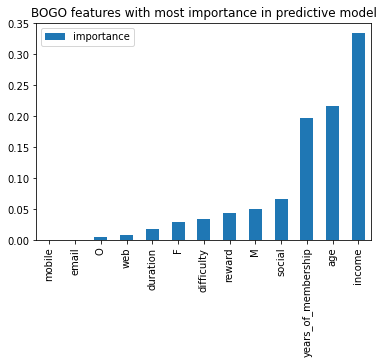

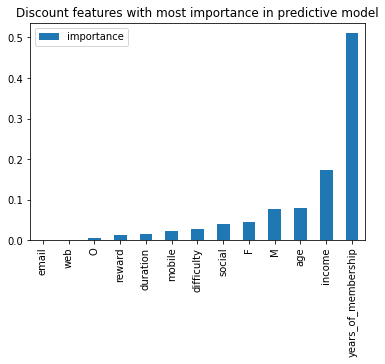

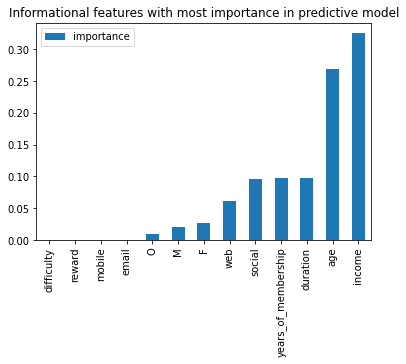

In [105]:
# display feature sorted by significance in predictive model

# bogo model
cols_to_drop = ['customer_id', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(bogo_full, cols_to_drop)

feature_importance = pd.DataFrame(bogo_randomforest_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance', ascending = True)
feature_importance.plot.bar()
plt.title('BOGO features with most importance in predictive model')
plt.show()

#discount model
cols_to_drop = ['customer_id', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(discount_full, cols_to_drop)

feature_importance = pd.DataFrame(discount_randomforest_2.feature_importances_,
                                   index = features.columns,
                                    columns = ['importance']).sort_values('importance', ascending = True)
feature_importance.plot.bar()
plt.title('Discount features with most importance in predictive model')
plt.show()

#informational model
cols_to_drop = ['customer_id','offer_id','effective_offer','offer_type']
features, target = data_prep(informational_full, cols_to_drop)

feature_importance = pd.DataFrame(informational_randomforest_2.feature_importances_,
                                   index = features.columns,
                                    columns = ['importance']).sort_values('importance', ascending = True)


feature_importance.plot.bar()
plt.title('Informational features with most importance in predictive model')
plt.show()

**From the graphs above it is apparent that the most important features for all offer types are `income`, `age`, and `years_of_membership` in varying orders.**

## Question 2. Can these features be used to predict whether an offer will be effective?

In [99]:
# compare the refined model against baseline and its preliminary version
results[['DecisionTreeClassifier_bogo_1', 'RandomForestClassifier_bogo_1', 'RandomForestClassifier_bogo_2']]

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.001095,0.031588,0.061256
test_score,0.632005,0.662045,0.665319
train_score,0.646253,0.670683,0.727715
train_time,0.010902,0.142321,0.249450


- From the table above, it is apparent that the **refined bogo randomforest model is more accurate** than both its initial version and the baseline model.

In [100]:
# compare the refined model against baseline and its preliminary version
results[['DecisionTreeClassifier_bogo_1','RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.001095,0.026710,0.011617
test_score,0.632005,0.685021,0.695992
train_score,0.646253,0.690117,0.700787
train_time,0.010902,0.139549,0.064475


- From the table above, it is apparent that the **refined discount randomforest model is more accurate** than both its initial version and the baseline model.

In [101]:
# compare the refined model against baseline and its preliminary version
results[['DecisionTreeClassifier_bogo_1','RandomForestClassifier_informational_1','RandomForestClassifier_informational_2']]

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_informational_1,RandomForestClassifier_informational_2
pred_time,0.001095,0.005321,0.018010
test_score,0.632005,0.801277,0.801277
train_score,0.646253,0.789167,0.789167
train_time,0.010902,0.028529,0.110026


- From the table above, it is apparent that the **randomforest model is more accurate** than the baseline decisiontree model.
- The unrefined and refined models have exactly the same accuracy scores, which indicates a limitation of the algorithm for this specific offer/dataset.


## Conclusion

The 2 main questions of the dataset were:
1. Which are the defining features of an effective offer?

The answer to the first question revealed that the same features had similar impact on whether an offer ended up being effective or not.

**For each offer type, in varying orders `income`, `age`, `years_of_membership` were the most important features.**

2. Can these features be used to predict whether an offer will be effective?

With some refinement, the randomforest models all proved more accurate than the baseline decisiontree model. 

- The refined randomforest bogo model had an accuracy of ~72%

- The refined randomforest discount model had an accuracy of ~70%

- The most accurate model was the refined randomforest informational model with an accuracy of ~80%.

Interestingly enough, the informational model proved most difficult to optimize. At this time, the suspected reasoning for this is due to the smaller size and imbalanced distribution of effective/ineffective offers in the informational dataset.

Improvements for the future model refinement include expanding the range/depth of the grid_search parameters, which were restricted in this analysis due by CPU limitations.